In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt

from tsa.preprocessing import get_sample_info, tpm_normalization, merge_replicates
from tsa.gpr import gpr
from tsa.gene_selection import score_normalization, plot_scores, best_n_genes
from tsa.clustering import cluster_genes
from tsa.alignment import time_series_alignment
from tsa.utils import inference_timeseries, all_numeric

plt.rcParams['figure.figsize'] = [8, 6]

# Input files

In [2]:
tpm_file = "data/GRCz11-TPM.tsv"
tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

template_samples_file = "data/white_mpf_samples.tsv"
query_samples_file = "data/levin_mpf_samples.tsv"
# query_samples_file = "data/white_mpf_samples.tsv"  # control
# query_samples_file = "data/marletaz_mpf_samples.tsv"

# currently ran for 
# 18906 genes with min(TPM) > 5 and median(TPM) > 0 (2 ConvergenceWarnings: gene 4096 and 4817)
# with 171 points (10 per original timepoint)
new_gpr = False
gpr_inference_file = "data/white_mpf_gpr.tsv"
gpr_scores_file = "data/white_mpf_score.tsv"

# showcase_gene = "ENSDARG00000000212"
showcase_gene = "ENSDARG00000000018"

In [3]:
# tpm_file = "data/XT9.1-TPM.tsv"
# tpms = pd.read_csv(tpm_file, sep="\t", index_col=0)

# template_samples_file = "data/owensA1_mpf_samples.tsv"
# # query_samples_file = "data/owensA1_mpf_samples.tsv"  # control
# # query_samples_file = "data/owensA2_mpf_samples.tsv"
# # query_samples_file = "data/owensB1_mpf_samples.tsv"
# query_samples_file = "data/tanA_mpf_samples.tsv"
# # query_samples_file = "data/tanB_mpf_samples.tsv"

# new_gpr = False
# gpr_inference_file = "data/owensA1_mpf_gpr.tsv"
# gpr_scores_file = "data/owensA1_mpf_score.tsv"

# showcase_gene = "ENSXETG00000000002"

# Infer expression over time for template genes

In [4]:
# preprocessing
template_samples = pd.read_csv(template_samples_file, sep="\t", index_col=0)
template_sample_order, template_time2samples = get_sample_info(template_samples)

template_tpms = tpm_normalization(tpms, template_sample_order, min_value=5, min_median_value=0, verbose=True)

template_tpms.head(3)

11063 genes with max below 5 TPM (34%)
2243 genes with median below or equal to 0 TPM (10%)
18906 genes, 90 samples left after filtering


,1-cell-1,1-cell-2,1-cell-3,1-cell-4,1-cell-5,2-cell-1,2-cell-2,2-cell-3,2-cell-4,2-cell-5,...,Day-4-1,Day-4-2,Day-4-3,Day-4-4,Day-4-5,Day-5-1,Day-5-2,Day-5-3,Day-5-4,Day-5-5
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000001,3.500623,3.193223,2.993834,3.134451,2.930888,3.063963,3.358324,3.177872,3.182704,3.292535,...,1.268145,0.875185,1.372952,0.953276,1.219284,1.252780,1.293310,1.701401,1.087258,0.985310
ENSDARG00000000002,1.798363,1.850706,1.549031,1.842664,1.618451,2.919417,2.731890,2.547173,2.881035,2.495728,...,2.909071,3.259391,3.423040,3.203155,2.933308,3.054464,3.049627,3.124625,2.925538,3.317229
ENSDARG00000000018,3.825139,3.883515,3.443959,3.688393,3.947403,4.004615,4.161532,4.129312,4.164329,3.913867,...,4.537668,4.042059,4.059302,4.259864,4.103876,4.459250,4.421675,4.362885,4.252356,4.371778


In [5]:
# help(gpr)

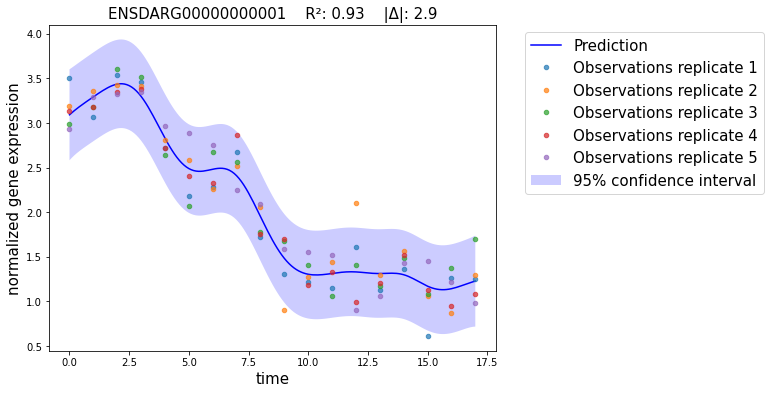

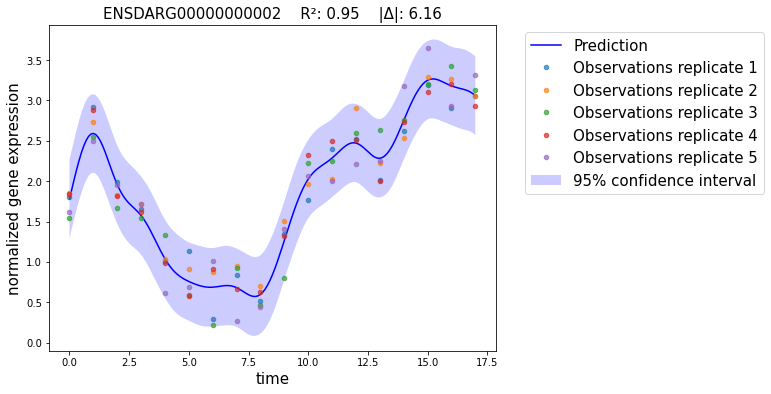

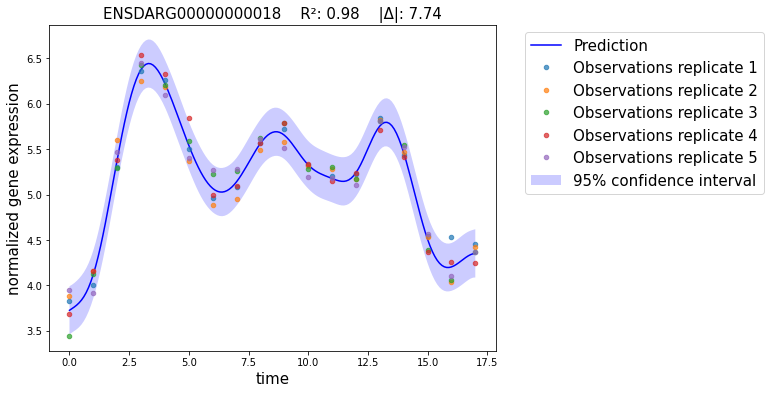

In [6]:
# # linear space
# extended_timepoints = list(np.round(np.linspace(min(time2samples), max(time2samples), 10), 2))

# infer n timepoints for each original timepoint 
timepoints_per_sample = 10
extended_timepoints = inference_timeseries(list(template_time2samples), timepoints_per_sample)

# run 3x with pictures
tmp, _ = gpr(template_time2samples, template_tpms, extended_timepoints, plot=True, verbose=False, run_n=3)

if new_gpr:
    # run with all genes
    template_tpms_inf, gpr_scores = gpr(template_time2samples, template_tpms, extended_timepoints, plot=False, verbose=True, run_n=None)
    
    template_tpms_inf.to_csv(gpr_inference_file, sep="\t")
    gpr_scores.to_csv(gpr_scores_file, sep="\t")
else:
    template_tpms_inf = pd.read_csv(gpr_inference_file, sep="\t", index_col=0)
    gpr_scores = pd.read_csv(gpr_scores_file, sep="\t", index_col=0)


In [7]:
# when loading a gpr inference table, make sure the rows and columns match the settings
if new_gpr is False:
    gene = tmp.index[0]
    if tmp.index[0] != template_tpms_inf.index[0]:
        raise ValueError("`template_tpms` gene order has changed since creating the template_tpms_inf table")
    if tmp.columns.equals(template_tpms_inf.columns):
        raise ValueError("`extended_timepoints` has changed since creating the template_tpms_inf table")
    print("all good!")

all good!


### Filter template genes by GPR model accuracy (R-squared), expression variability, or both.

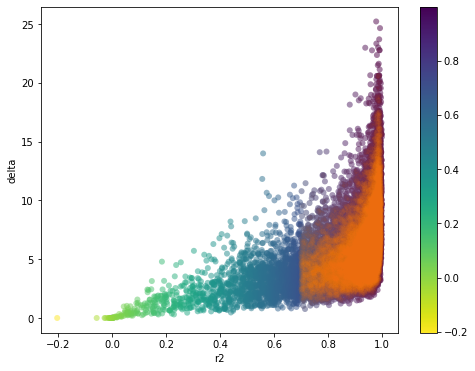

In [8]:
# remove genes that weren't modelled accurately
weight_expr=0
min_r2 = 0.7
weight_r2=1

gpr_scores.dropna(inplace=True)
gpr_normscores = score_normalization(gpr_scores, weight_expr, weight_r2)
top_template_genes = gpr_normscores[gpr_normscores.r2 >= min_r2].index.to_list()
plot_scores(gpr_normscores, highlight_top_n=len(top_template_genes))

# n = 12_000
# top_template_genes = best_n_genes(gpr_normscores, n)
# gpr_normscores = score_normalization(gpr_scores, weight_expr=1, weight_r2=3)
# plot_scores(gpr_normscores, highlight_top_n=n)

# Gene selection

In [9]:
# preprocessing
query_samples = pd.read_csv(query_samples_file, sep="\t", index_col=0)
sample_order, time2samples = get_sample_info(query_samples)

target_distribution = template_tpms[template_tpms.columns[0]].to_list()
query_tpms = tpm_normalization(tpms, sample_order, min_value=5, min_median_value=0, qnorm_target_dist=target_distribution)

# TODO: other methods, such as GPR?
query_tpms = merge_replicates(query_tpms, time2samples, how="mean")

if all_numeric(time2samples):
    # convert time to numeric
    samples2time = query_samples.to_dict()["time"]
    query_tpms = query_tpms.rename(columns=samples2time)

query_tpms.head(3)

14459 genes with max below 5 TPM (44%)
10529 genes with median below or equal to 0 TPM (59%)
7224 genes, 106 samples left after filtering


,40.0,80.0,120.0,160.0,200.0,240.0,280.0,320.0,360.0,400.0,...,3880.0,3920.0,3960.0,4000.0,4040.0,4080.0,4120.0,4160.0,4200.0,4240.0
gene,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000018,2.363360,1.299548,2.088214,2.226924,2.357048,2.139004,1.982364,1.486699,2.159773,2.328309,...,1.859068,2.107863,1.771334,2.646630,2.001946,1.938413,1.943625,1.541817,2.347557,1.822066
ENSDARG00000000019,2.389017,1.299548,1.866812,1.961443,2.405242,1.530620,2.556865,2.529278,1.387352,2.192920,...,2.049851,1.363728,0.799732,1.580856,1.621599,1.389890,0.799732,1.691948,2.107114,1.822066
ENSDARG00000000068,2.396414,1.299548,2.524144,0.888197,2.427770,2.416755,2.150868,1.486699,1.387352,1.288274,...,1.283175,0.799732,0.799732,1.580856,0.799732,1.874759,0.799732,1.969106,1.128612,1.822066


In [10]:
# overlap of query genes & top template genes
query_genes = query_tpms.index
starting_genes = set(top_template_genes).intersection(query_genes)

print(len(starting_genes), "overlapping genes")

# template_gene_clusters = cluster_genes(template_tpms_inf, starting_genes, n_clusters=None)

6886 overlapping genes


# TSA

In [11]:
import numpy as np
from tsa.alignment import get_cost_matrix, best_alignment_graph, _avg_alignments, plot_alignment, plot_gene
from tsa.utils import list2floats, all_numeric
import random

### with replacement

In [12]:
def avg_alignment(template_tpms_inf, query_tpms, gene_cluster_df, tries=10, frac=0.2, n=None, metric='correlation', showcase_gene=None, plot=True, verbose=True, return_std=False):
    paths = np.zeros((tries, query_tpms.shape[1]))
    
    clusters = list(set(gene_cluster_df.cluster))
    n_clusters = len(clusters)
    c_avg = int(n/n_clusters)
    for try_n in range(tries):
        if verbose:
            print(f"{int(100*try_n/tries)}%", end="\r")

        if frac is not None and n is None:
        # get a fraction of genes per cluster
            genes = gene_cluster_df.groupby("cluster").sample(frac=frac).index.to_list()
        elif n is not None and frac is None:
            genes = gene_cluster_df.groupby("cluster").sample(frac=frac, n=c_avg, replace=True).index.to_list()
#             genes = []
#             for cluster in clusters:
#                 c_genes = list(gene_cluster_df[gene_cluster_df.cluster == cluster].index)
#                 c_sample = min(len(c_genes), c_avg)
#                 genes.extend(random.sample(c_genes, c_sample))
        else:
            raise ValueError("use either `frac` or `n`")
            
        t = template_tpms_inf.loc[genes]
        q = query_tpms.loc[genes]

        cost_matrix = get_cost_matrix(t, q, metric)
        best_path, _ = best_alignment_graph(cost_matrix)

        paths[try_n] = best_path

    inference_time = list2floats(template_tpms_inf.columns)
    query_time = list2floats(query_tpms.columns)
    is_time_numeric = all_numeric(inference_time) and all_numeric(query_time)
    avg_path, std_path = _avg_alignments(paths, inference_time, is_time_numeric)
    
    if plot:
        n_genes = len(query_tpms)
        n_genes_used = len(q)
        print(f"\tAverage TSA of {tries} alignments with {n} genes \n"
              f"\t{n_clusters} clusters, ~{c_avg} genes per cluster")
#               f"\t{n_genes_used} of {n_genes} genes used")
#         if frac is not None:
#             print(f"Average TSA of {tries} alignments with {int(frac*100)}% of genes per cluster \n"
#                   f"({n_clusters} clusters, {n_genes_used} genes used of {n_genes} total genes)")
#         elif n is not None:
#             print(f"Average TSA of {tries} alignments with {n} genes (on average {c_avg} genes per cluster) \n"
#                   f"({n_clusters} clusters, {n_genes_used} genes used of {n_genes} total genes)")
        cm = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)
        plot_alignment(cm, avg_path, std_path)
        
#         if is_time_numeric:
#             # gene mapping only makes sense if both query and template are in numeric time
#             plot_gene(query_tpms, template_tpms_inf, avg_path, showcase_gene, scale=True)

    if return_std:
        return avg_path, std_path
    return avg_path

random sampling with replacement

	Average TSA of 100 alignments with 1000 genes 
	1 clusters, ~1000 genes per cluster


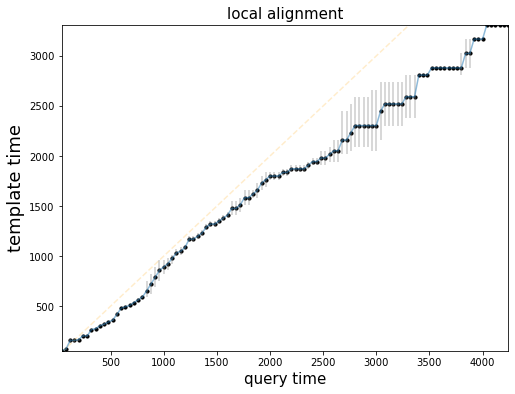

	Average TSA of 100 alignments with 1000 genes 
	2 clusters, ~500 genes per cluster


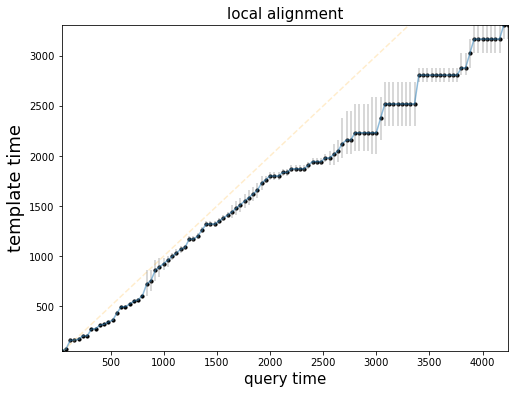

	Average TSA of 100 alignments with 1000 genes 
	3 clusters, ~333 genes per cluster


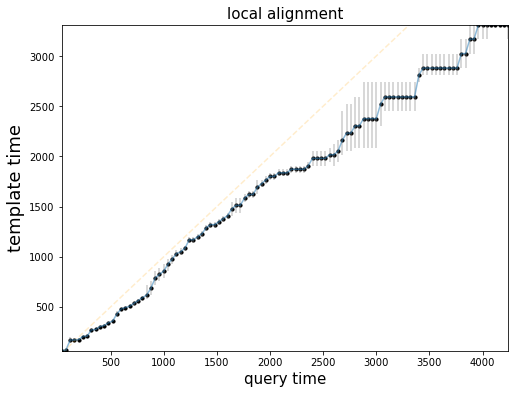

	Average TSA of 100 alignments with 1000 genes 
	4 clusters, ~250 genes per cluster


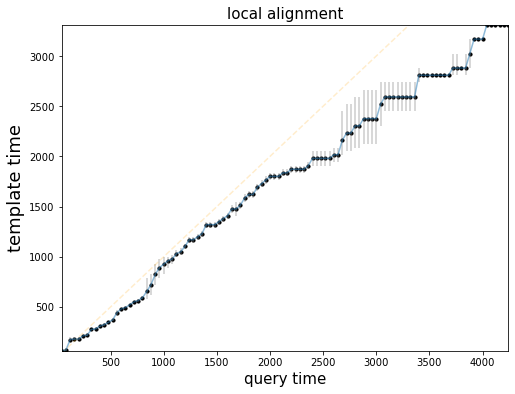

	Average TSA of 100 alignments with 1000 genes 
	5 clusters, ~200 genes per cluster


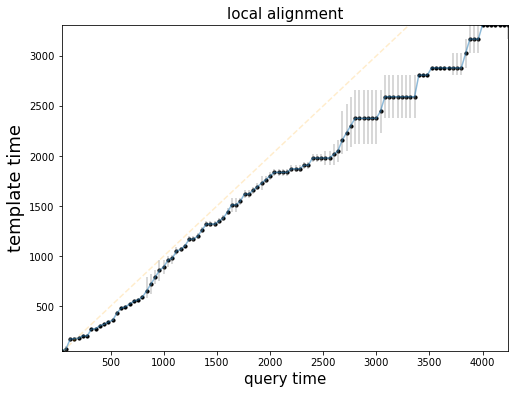

	Average TSA of 100 alignments with 1000 genes 
	6 clusters, ~166 genes per cluster


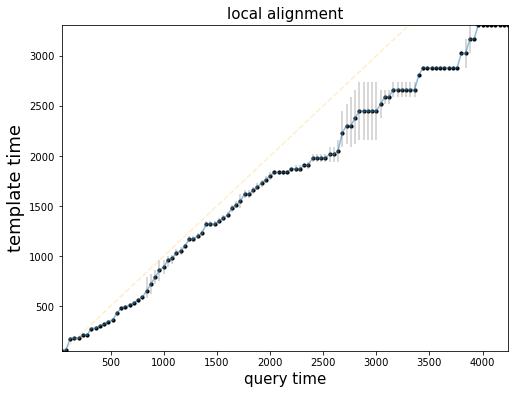

	Average TSA of 100 alignments with 1000 genes 
	7 clusters, ~142 genes per cluster


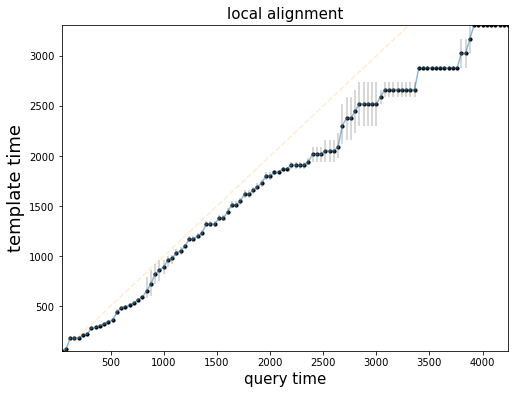

	Average TSA of 100 alignments with 1000 genes 
	8 clusters, ~125 genes per cluster


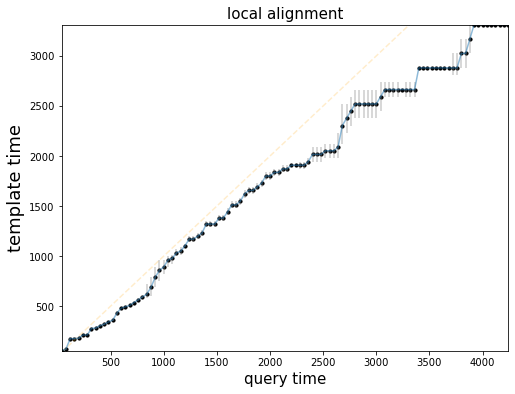

	Average TSA of 100 alignments with 1000 genes 
	9 clusters, ~111 genes per cluster


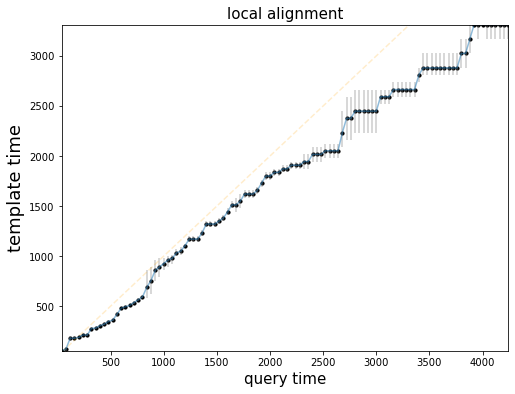

	Average TSA of 100 alignments with 1000 genes 
	10 clusters, ~100 genes per cluster


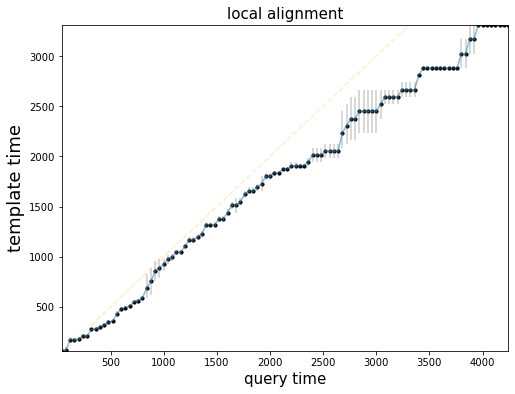

	Average TSA of 100 alignments with 1000 genes 
	11 clusters, ~90 genes per cluster


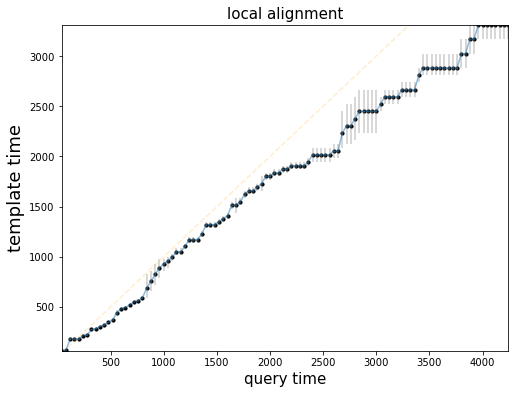

	Average TSA of 100 alignments with 1000 genes 
	12 clusters, ~83 genes per cluster


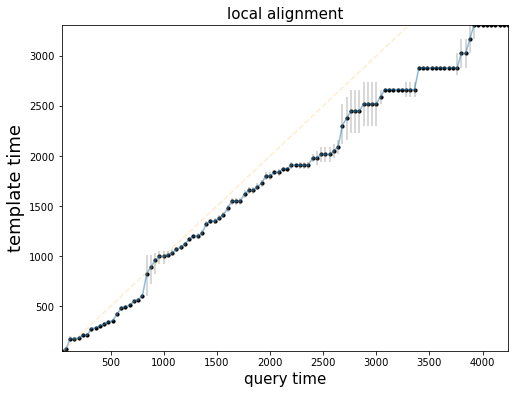

	Average TSA of 100 alignments with 1000 genes 
	13 clusters, ~76 genes per cluster


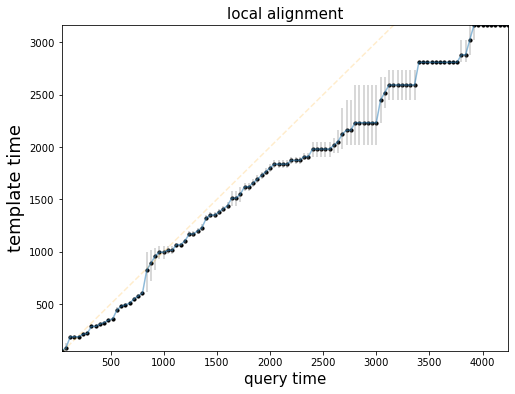

	Average TSA of 100 alignments with 1000 genes 
	14 clusters, ~71 genes per cluster


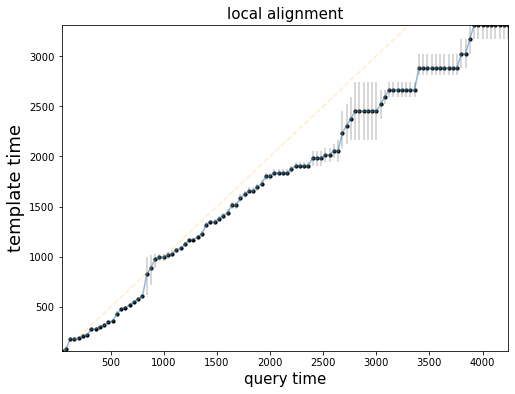

	Average TSA of 100 alignments with 1000 genes 
	15 clusters, ~66 genes per cluster


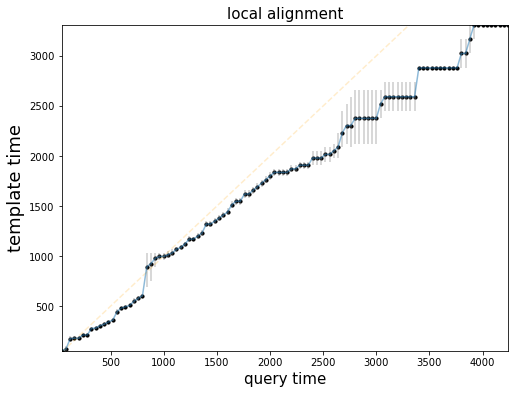

	Average TSA of 100 alignments with 1000 genes 
	16 clusters, ~62 genes per cluster


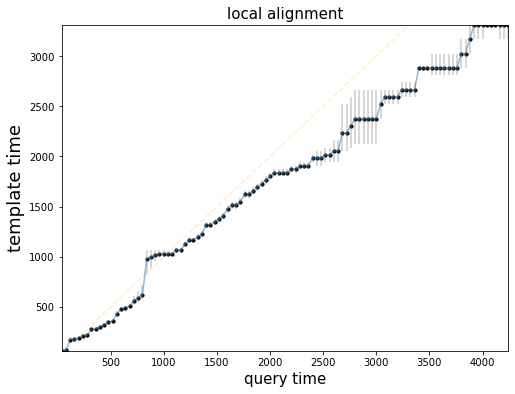

	Average TSA of 100 alignments with 1000 genes 
	17 clusters, ~58 genes per cluster


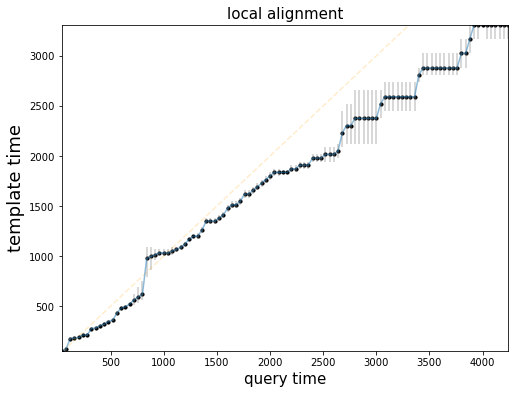

	Average TSA of 100 alignments with 1000 genes 
	18 clusters, ~55 genes per cluster


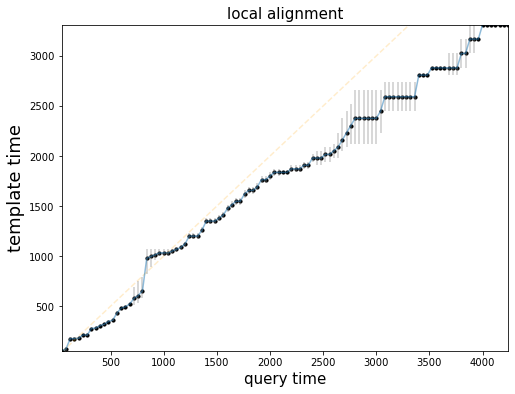

	Average TSA of 100 alignments with 1000 genes 
	19 clusters, ~52 genes per cluster


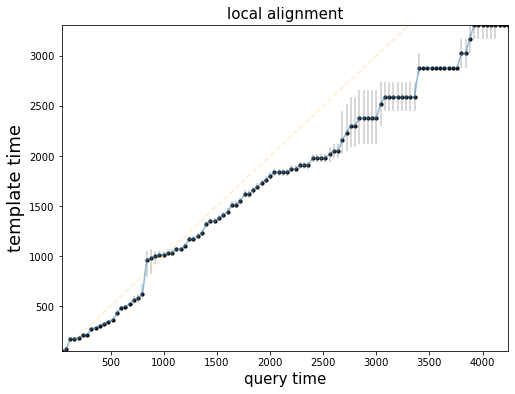

	Average TSA of 100 alignments with 1000 genes 
	20 clusters, ~50 genes per cluster


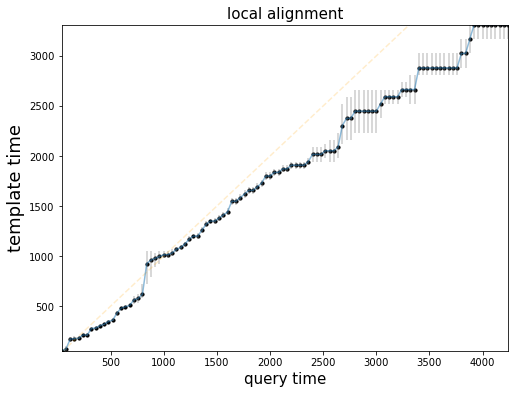

	Average TSA of 100 alignments with 1000 genes 
	21 clusters, ~47 genes per cluster


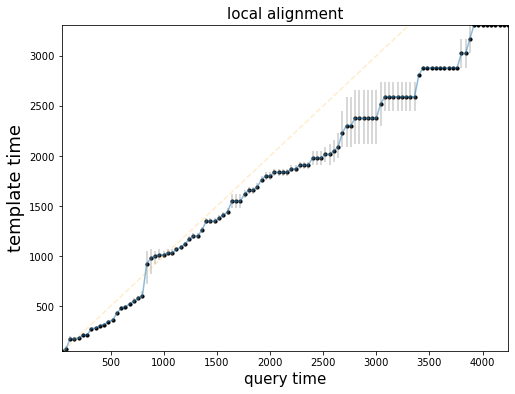

	Average TSA of 100 alignments with 1000 genes 
	22 clusters, ~45 genes per cluster


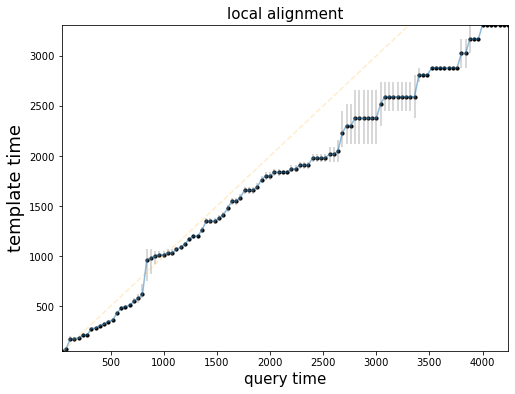

	Average TSA of 100 alignments with 1000 genes 
	23 clusters, ~43 genes per cluster


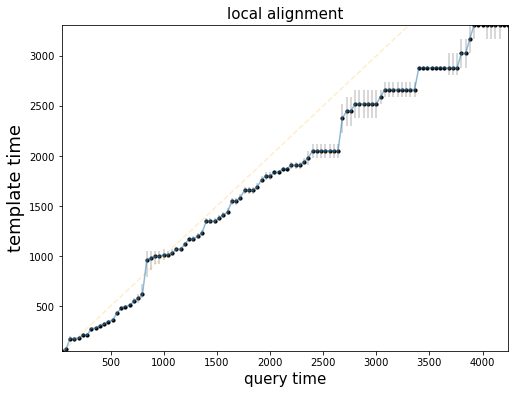

	Average TSA of 100 alignments with 1000 genes 
	24 clusters, ~41 genes per cluster


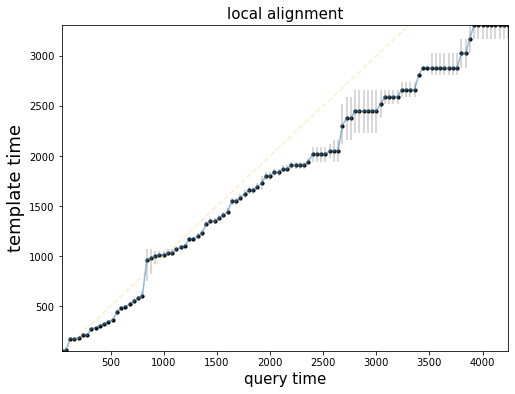

	Average TSA of 100 alignments with 1000 genes 
	25 clusters, ~40 genes per cluster


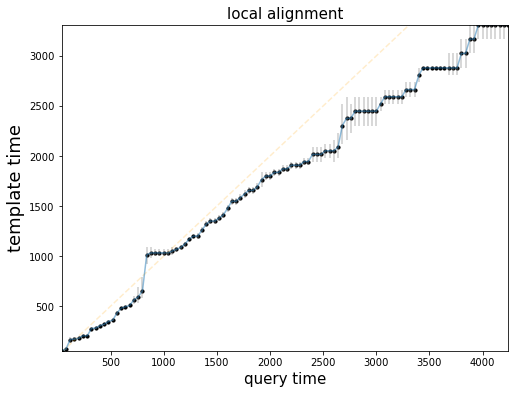

	Average TSA of 100 alignments with 1000 genes 
	26 clusters, ~38 genes per cluster


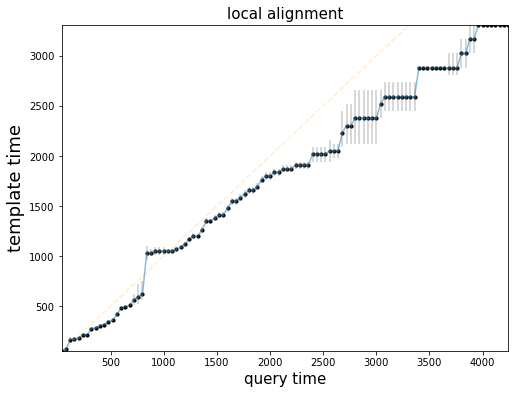

	Average TSA of 100 alignments with 1000 genes 
	27 clusters, ~37 genes per cluster


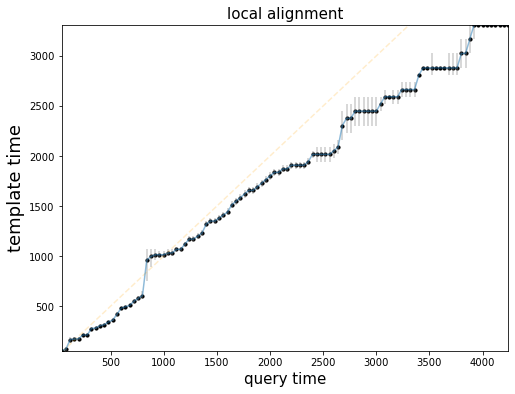

	Average TSA of 100 alignments with 1000 genes 
	28 clusters, ~35 genes per cluster


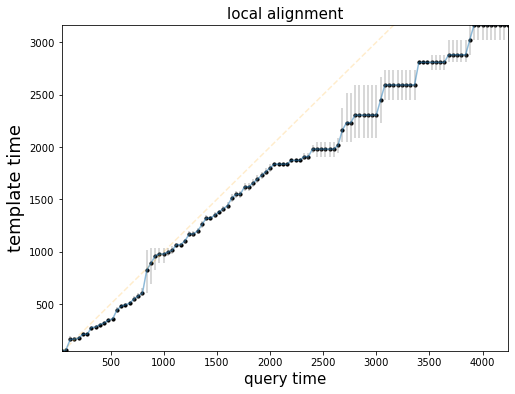

	Average TSA of 100 alignments with 1000 genes 
	29 clusters, ~34 genes per cluster


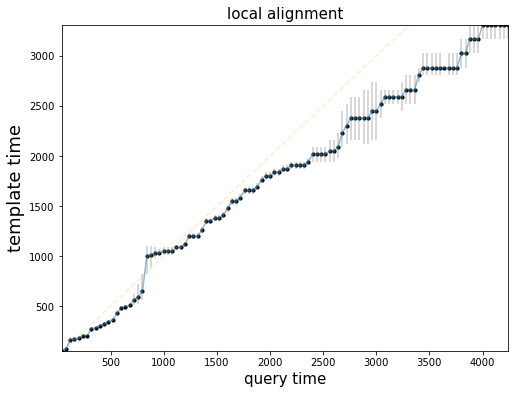

In [53]:
print("random sampling with replacement\n")

paths = []
n_genes = 1000
tries = 100
min_clust = 1
max_clust = 30
for n_clusters in range(min_clust, max_clust):
    template_gene_clusters = cluster_genes(template_tpms_inf, starting_genes, n_clusters=n_clusters)
    path = avg_alignment(template_tpms_inf, query_tpms, template_gene_clusters, tries=tries, frac=None, n=n_genes, showcase_gene=showcase_gene, return_std=True)
    paths.append(path)

In [62]:
query_time = list2floats(query_tpms.columns)
template_time = list2floats(template_tpms_inf.columns)

scores = []
spikes = []
smoothness = []
diffs = []
for p in range(len(paths)):
    path, stdev = paths[p]
    
    score = abs(stdev).mean()
    scores.append(score)
    
    inferred_time = [template_time[i] for i in path]
    
    spike = np.diff(inferred_time).max()
    spikes.append(spike)
    
    diff = [abs(inferred_time[i] - query_time[i]) for i in range(len(path))]
    smoothness.append(np.mean(diff))
    diffs.append(sum(diff))

print("White vs. Levin")
print(f"{n_genes} genes over {min_clust}-{max_clust-1} clusters")
print(f"(with resampling in undersized clusters, {tries} tries)")
print()
print("Lower (darker) values are better")
pd.DataFrame(
    {
        "n_clusters": list(range(min_clust, max_clust)), 
        "stdev": scores, 
        "largest jump": spikes, 
        "|\u0394| from perfect": smoothness,
#         "|\u0394| from perfect": diffs,
    }
).astype(int).set_index("n_clusters").style.background_gradient(cmap='viridis')

White vs. Levin
1000 genes over 1-29 clusters
(with resampling in undersized clusters, 100 tries)

Lower (darker) values are better


,stdev,largest jump,|Δ| from perfect
n_clusters,,,
1,68,216,393
2,84,288,410
3,79,216,378
4,61,216,387
5,72,216,376
6,50,180,364
7,50,216,347
8,46,216,346
9,71,180,353


### without replacement

In [63]:
def avg_alignment2(template_tpms_inf, query_tpms, gene_cluster_df, tries=10, frac=0.2, n=None, metric='correlation', showcase_gene=None, plot=True, verbose=True, return_std=False):
    paths = np.zeros((tries, query_tpms.shape[1]))
    
    clusters = list(set(gene_cluster_df.cluster))
    n_clusters = len(clusters)
    c_avg = int(n/n_clusters)
    for try_n in range(tries):
        if verbose:
            print(f"{int(100*try_n/tries)}%", end="\r")

        if frac is not None and n is None:
        # get a fraction of genes per cluster
            genes = gene_cluster_df.groupby("cluster").sample(frac=frac).index.to_list()
        elif n is not None and frac is None:
#             genes = gene_cluster_df.groupby("cluster").sample(frac=frac, n=c_avg, replace=True).index.to_list()
            genes = []
            for cluster in clusters:
                c_genes = list(gene_cluster_df[gene_cluster_df.cluster == cluster].index)
                c_sample = min(len(c_genes), c_avg)
                genes.extend(random.sample(c_genes, c_sample))
        else:
            raise ValueError("use either `frac` or `n`")
            
        t = template_tpms_inf.loc[genes]
        q = query_tpms.loc[genes]

        cost_matrix = get_cost_matrix(t, q, metric)
        best_path, _ = best_alignment_graph(cost_matrix)

        paths[try_n] = best_path

    inference_time = list2floats(template_tpms_inf.columns)
    query_time = list2floats(query_tpms.columns)
    is_time_numeric = all_numeric(inference_time) and all_numeric(query_time)
    avg_path, std_path = _avg_alignments(paths, inference_time, is_time_numeric)
    
    if plot:
        n_genes = len(query_tpms)
        n_genes_used = len(q)
        print(f"\tAverage TSA of {tries} alignments with {n} genes \n"
              f"\t{n_clusters} clusters, ~{c_avg} genes per cluster")
#               f"\t{n_genes_used} of {n_genes} genes used")
#         if frac is not None:
#             print(f"Average TSA of {tries} alignments with {int(frac*100)}% of genes per cluster \n"
#                   f"({n_clusters} clusters, {n_genes_used} genes used of {n_genes} total genes)")
#         elif n is not None:
#             print(f"Average TSA of {tries} alignments with {n} genes (on average {c_avg} genes per cluster) \n"
#                   f"({n_clusters} clusters, {n_genes_used} genes used of {n_genes} total genes)")
        cm = pd.DataFrame(cost_matrix, index=q.columns, columns=t.columns)
        plot_alignment(cm, avg_path, std_path)
        
#         if is_time_numeric:
#             # gene mapping only makes sense if both query and template are in numeric time
#             plot_gene(query_tpms, template_tpms_inf, avg_path, showcase_gene, scale=True)

    if return_std:
        return avg_path, std_path
    return avg_path

random sampling without replacement

	Average TSA of 100 alignments with 1000 genes 
	1 clusters, ~1000 genes per cluster


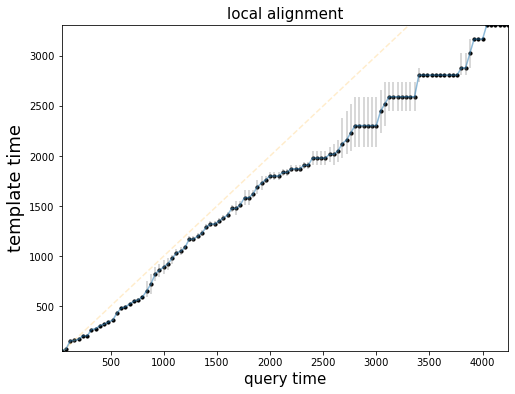

	Average TSA of 100 alignments with 1000 genes 
	2 clusters, ~500 genes per cluster


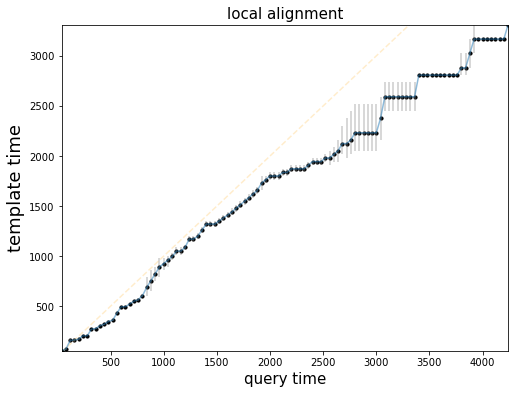

	Average TSA of 100 alignments with 1000 genes 
	3 clusters, ~333 genes per cluster


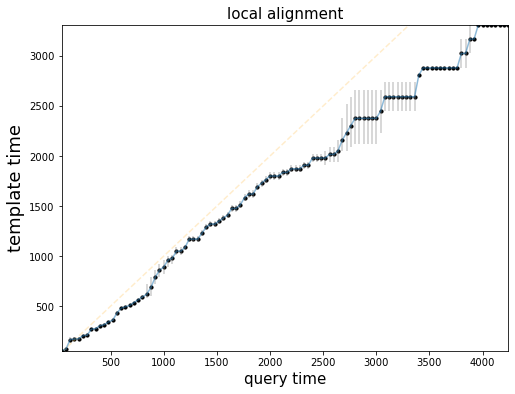

	Average TSA of 100 alignments with 1000 genes 
	4 clusters, ~250 genes per cluster


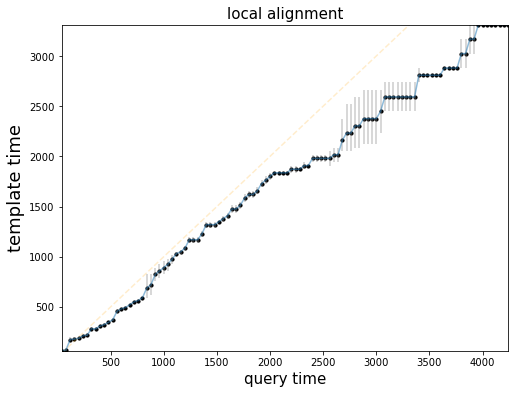

	Average TSA of 100 alignments with 1000 genes 
	5 clusters, ~200 genes per cluster


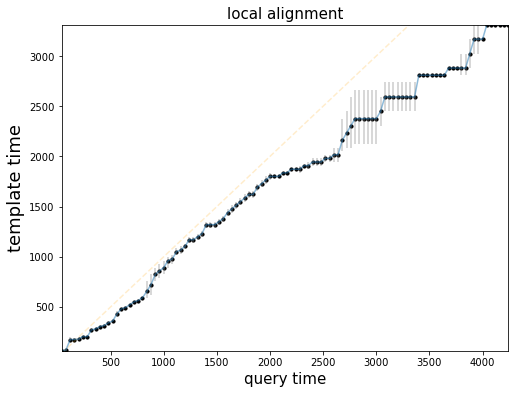

	Average TSA of 100 alignments with 1000 genes 
	6 clusters, ~166 genes per cluster


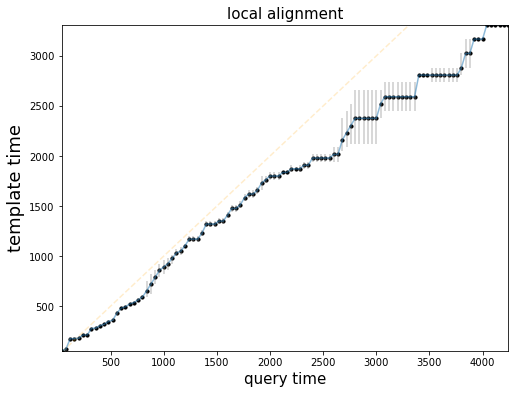

	Average TSA of 100 alignments with 1000 genes 
	7 clusters, ~142 genes per cluster


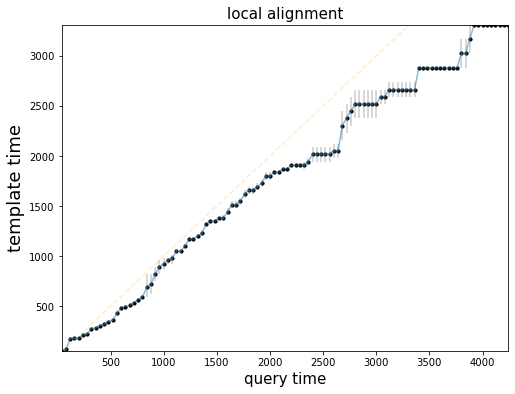

	Average TSA of 100 alignments with 1000 genes 
	8 clusters, ~125 genes per cluster


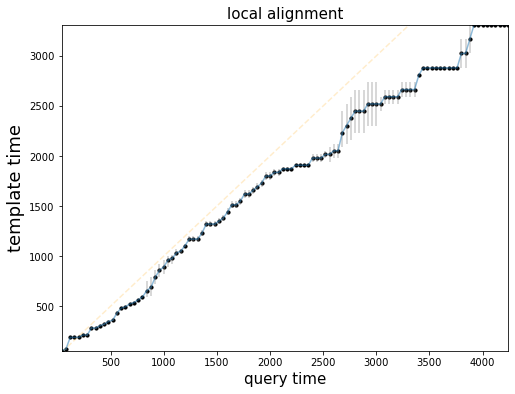

	Average TSA of 100 alignments with 1000 genes 
	9 clusters, ~111 genes per cluster


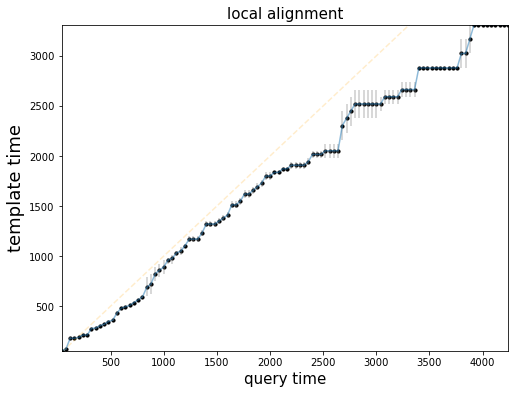

	Average TSA of 100 alignments with 1000 genes 
	10 clusters, ~100 genes per cluster


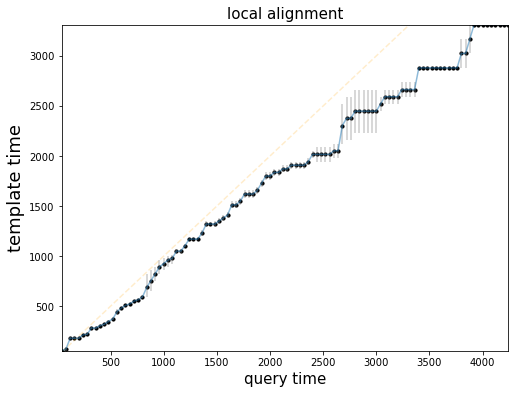

	Average TSA of 100 alignments with 1000 genes 
	11 clusters, ~90 genes per cluster


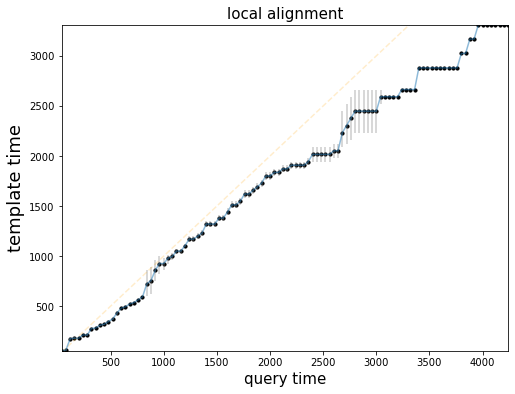

	Average TSA of 100 alignments with 1000 genes 
	12 clusters, ~83 genes per cluster


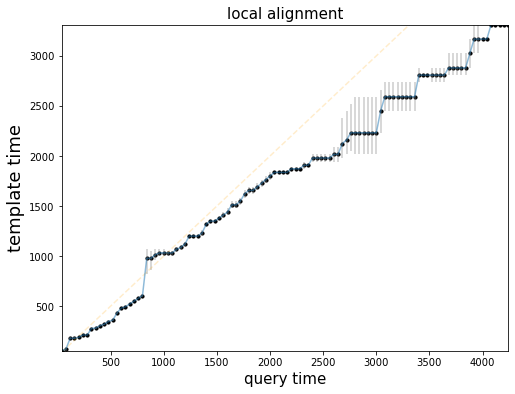

	Average TSA of 100 alignments with 1000 genes 
	13 clusters, ~76 genes per cluster


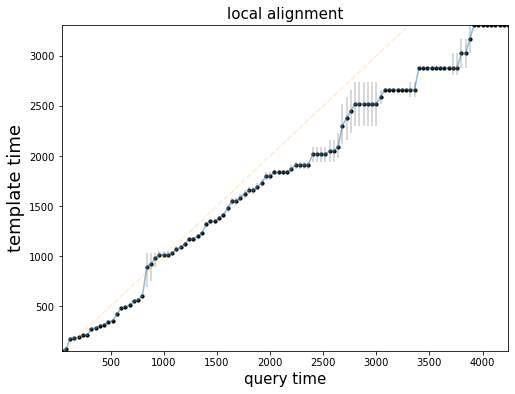

	Average TSA of 100 alignments with 1000 genes 
	14 clusters, ~71 genes per cluster


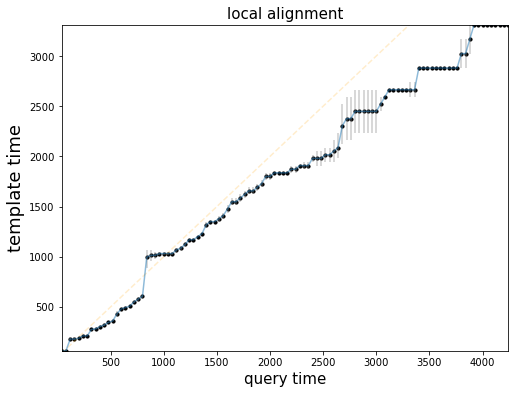

	Average TSA of 100 alignments with 1000 genes 
	15 clusters, ~66 genes per cluster


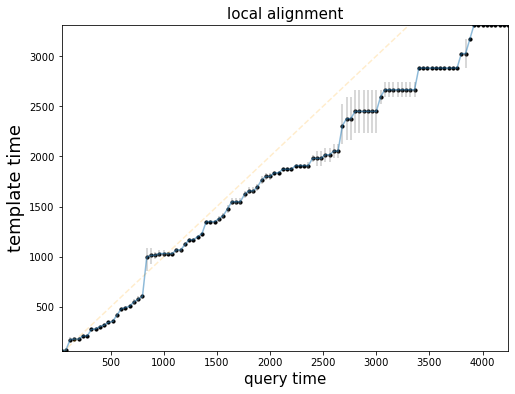

	Average TSA of 100 alignments with 1000 genes 
	16 clusters, ~62 genes per cluster


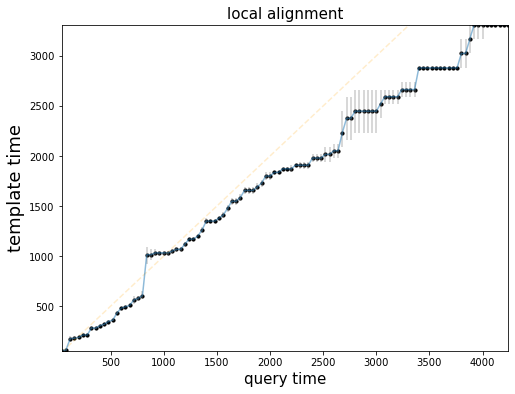

	Average TSA of 100 alignments with 1000 genes 
	17 clusters, ~58 genes per cluster


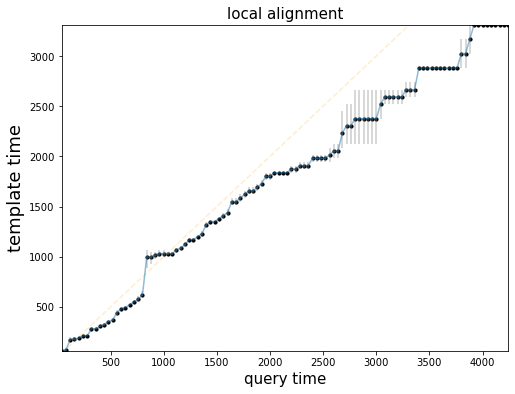

	Average TSA of 100 alignments with 1000 genes 
	18 clusters, ~55 genes per cluster


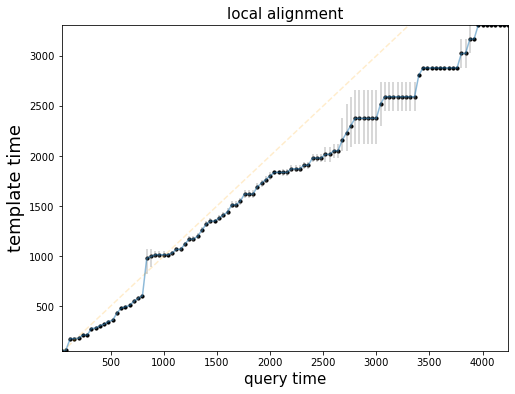

	Average TSA of 100 alignments with 1000 genes 
	19 clusters, ~52 genes per cluster


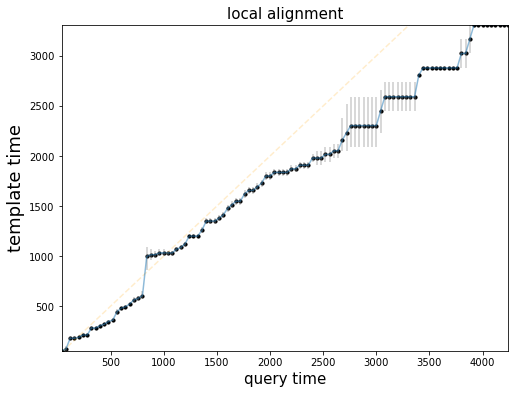

	Average TSA of 100 alignments with 1000 genes 
	20 clusters, ~50 genes per cluster


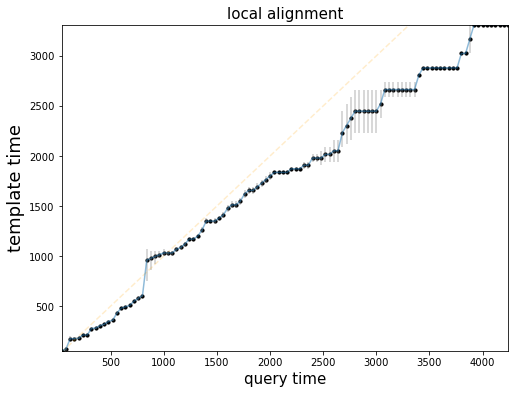

	Average TSA of 100 alignments with 1000 genes 
	21 clusters, ~47 genes per cluster


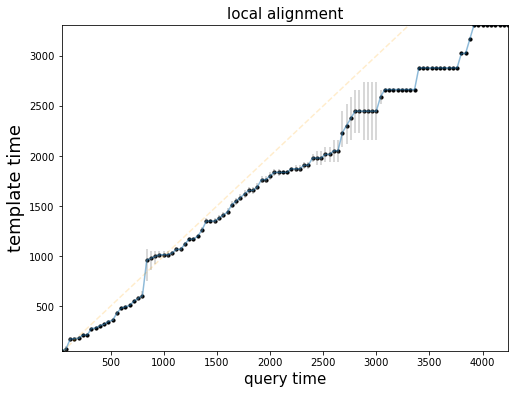

	Average TSA of 100 alignments with 1000 genes 
	22 clusters, ~45 genes per cluster


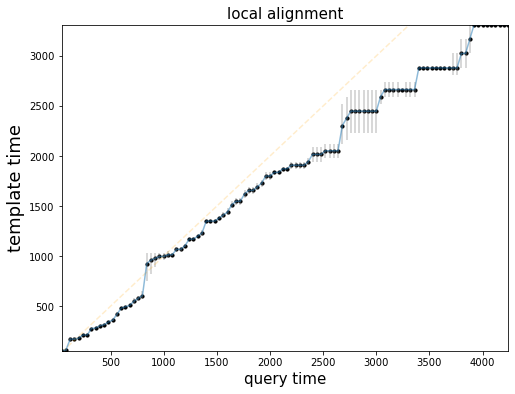

	Average TSA of 100 alignments with 1000 genes 
	23 clusters, ~43 genes per cluster


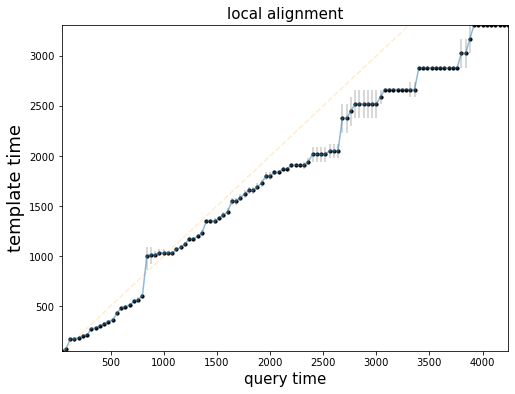

	Average TSA of 100 alignments with 1000 genes 
	24 clusters, ~41 genes per cluster


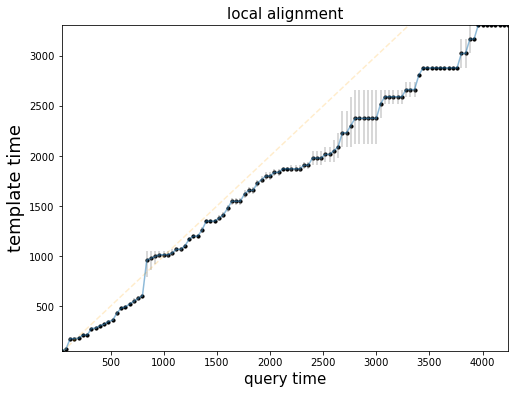

	Average TSA of 100 alignments with 1000 genes 
	25 clusters, ~40 genes per cluster


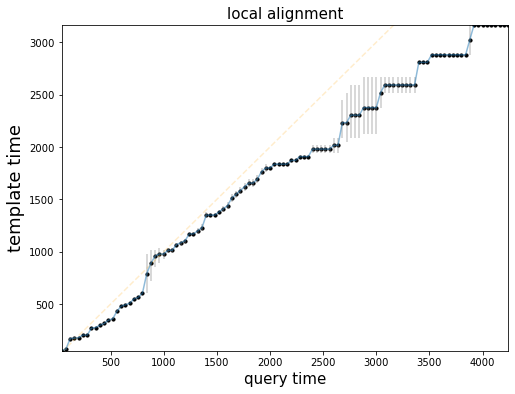

	Average TSA of 100 alignments with 1000 genes 
	26 clusters, ~38 genes per cluster


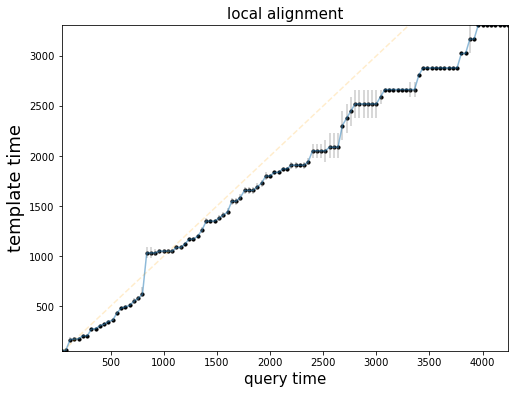

	Average TSA of 100 alignments with 1000 genes 
	27 clusters, ~37 genes per cluster


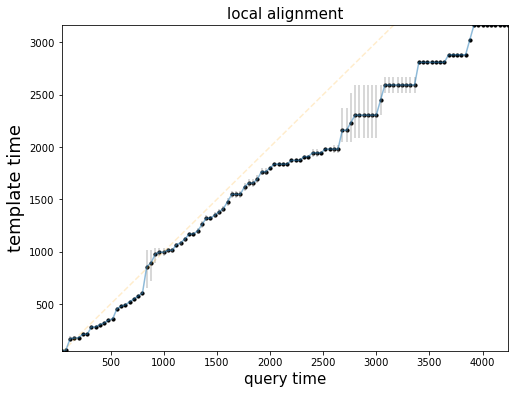

	Average TSA of 100 alignments with 1000 genes 
	28 clusters, ~35 genes per cluster


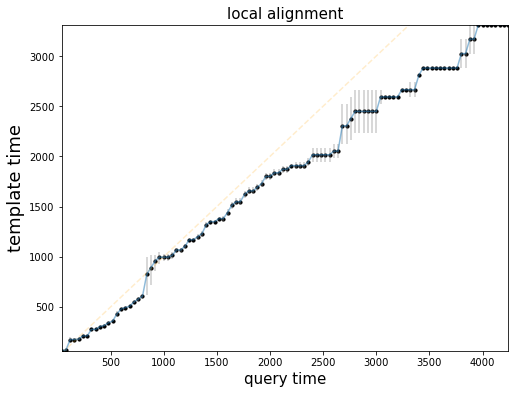

	Average TSA of 100 alignments with 1000 genes 
	29 clusters, ~34 genes per cluster


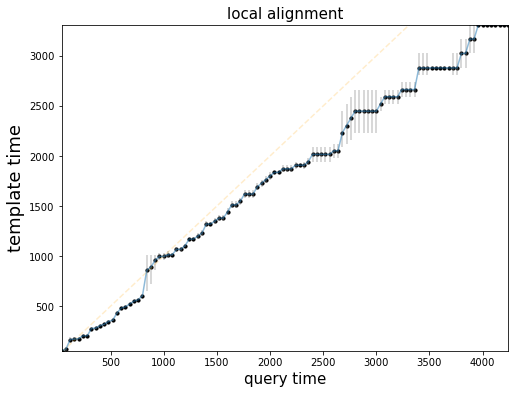

In [66]:
print("random sampling without replacement\n")

paths2 = []
for n_clusters in range(min_clust, max_clust):
    template_gene_clusters = cluster_genes(template_tpms_inf, starting_genes, n_clusters=n_clusters)
    path = avg_alignment2(template_tpms_inf, query_tpms, template_gene_clusters, tries=tries, frac=None, n=n_genes, showcase_gene=showcase_gene, return_std=True)
    paths2.append(path)

In [68]:
query_time = list2floats(query_tpms.columns)
template_time = list2floats(template_tpms_inf.columns)

scores = []
spikes = []
smoothness = []
diffs = []
for p in range(len(paths2)):
    path, stdev = paths2[p]
    
    score = abs(stdev).mean()
    scores.append(score)
    
    inferred_time = [template_time[i] for i in path]
    
    spike = np.diff(inferred_time).max()
    spikes.append(spike)
    
    diff = [abs(inferred_time[i] - query_time[i]) for i in range(len(path))]
    smoothness.append(np.mean(diff))
    diffs.append(sum(diff))

print("White vs. Levin")
print(f"{n_genes} genes over {min_clust}-{max_clust-1} clusters")
print(f"(without resampling in undersized clusters, {tries} tries)")
print()
print("Lower (darker) values are better")
pd.DataFrame(
    {
        "n_clusters": list(range(min_clust, max_clust)), 
        "stdev": scores, 
        "largest jump": spikes, 
        "|\u0394| from perfect": smoothness,
#         "|\u0394| from perfect": diffs,
    }
).astype(int).set_index("n_clusters").style.background_gradient(cmap='viridis')

White vs. Levin
1000 genes over 1-29 clusters
(without resampling in undersized clusters, 100 tries)

Lower (darker) values are better


,stdev,largest jump,|Δ| from perfect
n_clusters,,,
1,61,216,395
2,56,216,407
3,58,216,376
4,56,216,380
5,55,216,386
6,59,216,388
7,38,252,345
8,44,180,358
9,40,252,350


### save notebook

In [ ]:
# from nbconvert import HTMLExporter
# import codecs
# import nbformat

# notebook_name = 'clustering.ipynb'
# output_file_name = 'output.html'

# exporter = HTMLExporter()
# output_notebook = nbformat.read(notebook_name, as_version=4)

# output, resources = exporter.from_notebook_node(output_notebook)
# codecs.open(output_file_name, 'w', encoding='utf-8').write(output)

In [70]:
import codecs
import nbformat as nbf
from nbconvert.exporters import HTMLExporter
from nbconvert.preprocessors import TagRemovePreprocessor
from traitlets.config import Config

# Setup config
c = Config()

# Configure tag removal - be sure to tag your cells to remove  using the
# words remove_cell to remove cells. You can also modify the code to use
# a different tag word
c.TagRemovePreprocessor.remove_cell_tags = ("remove_cell",)
c.TagRemovePreprocessor.remove_all_outputs_tags = ('remove_output',)
c.TagRemovePreprocessor.remove_input_tags = ('remove_input',)
c.TagRemovePreprocessor.enabled = True

# Configure and run out exporter
c.HTMLExporter.preprocessors = ["nbconvert.preprocessors.TagRemovePreprocessor"]

exporter = HTMLExporter(config=c)
exporter.register_preprocessor(TagRemovePreprocessor(config=c),True)

notebook_name = 'clustering.ipynb'
output_file_name = 'clustering.html'

# Configure and run our exporter - returns a tuple - first element with html,
# second with notebook metadata
output_notebook = nbf.read(notebook_name, as_version=4)

# Write to output html file
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(output_file_name, 'w', encoding='utf-8').write(output)

In [ ]:
# from traitlets.config import Config
# import nbformat as nbf
# from nbconvert.exporters import HTMLExporter
# from nbconvert.preprocessors import TagRemovePreprocessor

# # Setup config
# c = Config()

# # Configure tag removal - be sure to tag your cells to remove  using the
# # words remove_cell to remove cells. You can also modify the code to use
# # a different tag word
# c.TagRemovePreprocessor.remove_cell_tags = ("remove_cell",)
# c.TagRemovePreprocessor.remove_all_outputs_tags = ('remove_output',)
# c.TagRemovePreprocessor.remove_input_tags = ('remove_input',)
# c.TagRemovePreprocessor.enabled = True

# # Configure and run out exporter
# c.HTMLExporter.preprocessors = ["nbconvert.preprocessors.TagRemovePreprocessor"]

# exporter = HTMLExporter(config=c)
# exporter.register_preprocessor(TagRemovePreprocessor(config=c),True)

# # Configure and run our exporter - returns a tuple - first element with html,
# # second with notebook metadata
# output = HTMLExporter(config=c).from_filename("your-notebook-file-path.ipynb")

# # Write to output html file
# with open("your-output-file-name.html",  "w") as f:
#     f.write(output[0])